# Primary Productivity Relative Difference Analysis  
## Relative difference analysis of the interim and legacy products
> History | Updated Apr 2024  

## Objectives
Calculate the mean absolute relative difference (&Delta;<sub>rel</sub>) of the interim VIIRS netPP product (netPP<sub>VIIRS</sub>) and legacy MODIS netPP product (netPP<sub>MODIS</sub>) within a user-specified region for each month from 2013-2022. The result will be a 120-month (10-year) mean monthly timeseries of &Delta;<sub>rel</sub> within your area of interest. 

* &Delta;<sub>rel</sub> was calculated as the difference between VIIRS-SNPP (netPP<sub>VIIRS</sub>) and MODIS-Aqua netPP (netPP<sub>MODIS</sub>)  values divided by netPP<sub>MODIS</sub>.  
* Normalizing by netPP<sub>MODIS</sub> allow users to evaluate how much difference to expect in the netPP values used in their applications when switching to the interim product.  

### Steps:    
> * Download an area of monthly  &Delta;<sub>rel</sub> values from the ERDDAP server for each month from 2013-2022.  
> * Mask the timeseries so that only data within a shapefile is retained.  
> * Calculate the mean values of &Delta;<sub>rel</sub> for each month. 
> * Visualized the timeseries and save the data.  

## Satellite Datasets:  
#### Absolute Relative Difference (&Delta;<sup>netPP</sup>), VIIRS(SNPP)-MODIS(Aqua), Global, Monthly, 9km, 2013-2022   
The absolute relative difference (&Delta;<sup>netPP</sup>) was calculated, for each pixel, as the difference between VIIRS and MODIS values for that pixel divided by the mean of VIIRS and MODIS.  

$
\Large\Delta^{netPP} = \frac{netPP_{VIIRS} - netPP_{MODIS}}{netPP_{MODIS}}\
$  

For this dataset, we generated the pixel-by-pixel absolute relative difference (&Delta;<sup>netPP</sup>) for the globe for each month between January 2013 to December 2022 at 9 kilometer spatial resolution. The dataset is distributed via the West Coast Node ERDDAP data server at the following link:  
> http://localhost:8080/erddap/griddap/netpp_delta_snpp_modis.graph   

That dataset will be used in this notebook to generate a timeseries of monthly mean values of &Delta;<sup>netPP</sup>. We will access the data using the xr_open_ds() function below. The function requires:  
* the url of the ERDDAP server being use, in this case "http://localhost:8080"
* the ID of the dataset, in this case "netpp_delta_snpp_modis".

Let's put those items into separate variables. 



In [20]:
# set the url of the ERDDAP server
erddap_url = "http://localhost:8080/"

# set the dataset ID
erddap_id = 'netpp_delta_snpp_modis'

from IPython.display import Image 

## Shapfiles
#### Longhurst Marine Provinces  
The dataset represents the division of the world oceans into provinces as defined by Longhurst (1995; 1998; 2006). This division has been based on the prevailing role of physical forcing as a regulator of phytoplankton distribution. The Longhurst Marine Provinces dataset is available online (https://www.marineregions.org/downloads.php) and within the shapes folder associated with this repository.  

<img src="images/longhurst.png"></img>

__For our example we will use the shapefile for the  "California Upwelling Coastal Province" (ProvCode: CCAL) within the Longhurst Marine Provinces classification__. 

## Resource requirements
-   Jupyter Notebook  
-   Python 3 with the modules included within the "Import packages" section below.   
-   A shapefile with your area of interest  
    * If you don't have shapefile, we will include some workarounds in the notebook.  
-   An Internet connection  

## Import packages

In [21]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import regionmask
import pandas as pd
import warnings
import os
import numpy as np
warnings.filterwarnings('ignore')

## Create a few useful functions
### Function to make an Xarray dataset connection to an ERDDAP dataset

In [22]:
def xr_open_ds(e_id, e_source='https://coastwatch.pfeg.noaa.gov', dap='griddap'):
    """Open a remote ERDDAP dataset.

    Args:
        e_id (str): ERDDAP dataset ID.
        e_source (str, optional): URL to ERDDAP server. Defaults to 'https://coastwatch.pfeg.noaa.gov/'.

    Returns:
        array: Xarray dataset object
    """
    # remove any trailing /
    e_source = e_source.rstrip("/")

    erddap_url = '/'.join([e_source,
                           'erddap',
                           dap,
                           e_id
                           ])

    return xr.open_dataset(erddap_url)

### Function to spatially subset an Xarray dataset using latitude and longitude

In [23]:
def subset_ds(full_ds, var_name, bnds_dic):
    """Make a spatial subset a satellite dataset.

    Args:
        full_ds (array): 2D or 3D array with lat and lon coordinate variables
        var_name (str): Name of varaible to subset.
        bnds_dic (dic): Dictionary holding lat and lon max and min values

    Returns:
        array: Xarray dataset object
    """
    # correct for reversed latitude order on a dataset
    if full_ds.latitude[0] > full_ds.latitude[-1]:
        lt_first = bnds_dic['lat_max']
        lt_last = bnds_dic['lat_min']
    else:
        lt_first = bnds_dic['lat_min']
        lt_last = bnds_dic['lat_max']
    
    # subset the dataset
    return full_ds[var_name].sel(latitude=slice(lt_first, 
                                                lt_last),
                                 longitude=slice(bnds_dic['lon_min'],
                                                 bnds_dic['lon_max'])
                                )

## Load the Longhurst Provinces shape files into a geopandas dataframe
For our example we will use the shapefile for the  "California Upwelling Coastal Province" (ProvCode: CCAL) within the Longhurst Marine Provinces classification. 
* In this step we will also isolate the California Upwelling Coastal Province. Uncomment  print(shapefiles[40:45]) to see where the shapefile is in the dataframe.

In [24]:
# create path to shapefile dataset
shape_path = os.path.join('..',
                          '..',
                          'shapes',
                          'longhurst',
                          'Longhurst_world_v4_2010.shp'
                          )

# create a dataframe
shapefiles = geopandas.read_file(shape_path)

# uncomment net line to see the California Upwelling Coastal Province entry
# print(shapefiles[40:45])

ProvCode = "CCAL"
coastal_CA = shapefiles.loc[shapefiles["ProvCode"] == ProvCode]
coastal_CA

,ProvCode,ProvDescr,geometry
43,CCAL,Coastal - California Upwelling Coastal Province,"MULTIPOLYGON (((-110.50000 24.50000, -110.5000..."


## Create the regional mask for the California Upwelling Coastal Province
Display the region after creating it. 

<GeoAxesSubplot:>

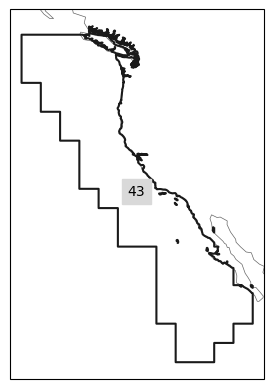

In [25]:
region = regionmask.from_geopandas(coastal_CA)
region.plot()

## Find the coordinates of the bounding box
* The bounding box is the smallest rectangle that will completely enclose the province. 
* We will use the bounding box coordinates to subset the satellite data. 

In [26]:
gs_bnds = coastal_CA.bounds
gs_bnds

,minx,miny,maxx,maxy
43,-134.5,16.5,-110.5,51.383431


### To make it easier to use the subset_ds() function without a shapefile, put the bounding box coordinates in a Python dictionary.

In [27]:
geo_bnds = {}
geo_bnds['lon_min'] = gs_bnds.minx.item()
geo_bnds['lon_max'] = gs_bnds.maxx.item()
geo_bnds['lat_min'] = gs_bnds.miny.item()
geo_bnds['lat_max'] = gs_bnds.maxy.item()


## Open the &Delta;<sup>netPP</sup> dataset into an xarray dataset object.
Pass the dataset ID and the ERDDAP server location to the xr_open_ds() function.  
* Check the document string for the xr_open_ds() function for more information. 
* Just a reminder that we set the erddap_id and erddap_url variable above.
* The ERDDAP dataset ID is "netpp_psi_snpp_modis"

In [28]:
ds = xr_open_ds(erddap_id,
                e_source=erddap_url)

ds

<xarray.Dataset>
Dimensions:    (time: 120, latitude: 2160, longitude: 4320)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-16T08:00:00 ... 2022-12-16T08:00:00
  * latitude   (latitude) float64 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Data variables:
    delta      (time, latitude, longitude) float32 ...
Attributes: (12/44)
    acknowledgement:           This project was supported by the NOAA Office ...
    cdm_data_type:             Grid
    contributor:               Dale Robinson, Isaac Schroeder
    contributor_role:          development and project management, production...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_name:              NOAA CoastWatch West Coast Node
    ...                        ...
    summary:                   The relative difference (rel_delta) between pr...
    time_coverage_end:         2022-12-16T08:00:00Z
    time_coverage_resolution:  P1M
    time_coverage_start:       2013-01-16T08:00:00Z
    title:                     Relative Difference of Net Primary Productivit...
    Westernmost_Easting:       -179.9583

### Note that the Data variable (above output) is named "delta".  
* We will need that name when using the subset_ds() function.
* Let's put the Data variable name into a variable.     

In [29]:
# Set erddap_var with data variable name
erddap_var = 'delta'

## Subset the satellite data
* Pass the geo_bnds variable containing bounding box coordinates to the subset_ds() function.  

__The result will be a dataset that is:__  
* Spatially subsetted to the dimensions of the bounding box that contains all 120 months of the ten-year period between 2013-2022

In [30]:
subsetted_ds = subset_ds(ds, erddap_var, geo_bnds)

## Determine the approximate download size
Before downloading the data, it is good to estimate how big your data request to ERDDAP will be. 
* The data still has not been downloaded. That will happen later when an operation that needs the data is initiated. 

Depending on the installation, ERDDAP has maximum single download limit of 2 Gigabytes.  
* That seems large but with satellite dataset large data volume add up fast.

The calculation for data download size estimate is below. 
* If the download size is nearing the single download limit, try splitting your download request into 2 or several separate requests and concatenate the data from the separate request.  

#### The request in this example is around 85 MB, well within the single download limit  

In [31]:
pixel_lon_axis = subsetted_ds.longitude.shape[0]
pixel_lon_axis = subsetted_ds.latitude.shape[0]

float_memory_size = 4
no_of_timesteps = subsetted_ds.time.shape[0]

download_size = (pixel_lon_axis
                 * pixel_lon_axis
                 * float_memory_size 
                 * no_of_timesteps)

print("download_size", int(download_size)/1000000, 'Mb')


download_size 84.26928 Mb


## Create a mask and apply it to the data
__The result will be datasets that are:__  
* Masked to retain only the data within the shapefile. 

In [32]:
# Create the mask
mask = region.mask(subsetted_ds.longitude, subsetted_ds.latitude)

# Apply mask the the satellite data
delta_ds = subsetted_ds.where(mask == region.numbers[0])

# set workaround flag
wa_flag = False


## Workaround if you do not have a shapefile

If you don't have a shapefile, you can instead select a rectangular area define by a latitude and a longitude range that encompasses your area of interest.  

#### Please see [Appendix B: Steps for use without a shapfile](#no_shapefile) below.


## Calculate the monthly mean for each month to create a timeseries.
For each month of the 120-month timeseries from 2013-2022 generate the mean &Delta;<sup>netPP</sup>.  
 
$
\Large\bar{\Delta}^{netPP}  = \frac{1}{N}\ \sum_{i=1}^{N} \Delta^{netPP}_{i}
$   

 * Where for each month N is the the number of pixels (<i>i</i>) within a month's grid with &Delta;<sup>netPP</sup> values . 

#### For our example using the shape file. The workaround results will be different:
* <span style="text-decoration: overline;">&Delta;</span><sup>netPP</sup> values in general were between -0.05 and 0.10 over most of the timeseries, meaning netPP<sub>VIIRS</sub> was -5% to +10% of the value for netPP<sub>MODIS</sub>.  
* <span style="text-decoration: overline;">&Delta;</span><sup>netPP</sup> showed greater variability from 2022-2023.

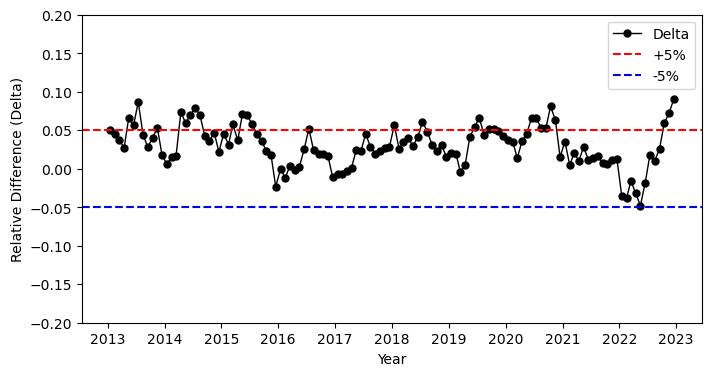

In [33]:
# generate the timeseries
delta_mean = delta_ds.mean(dim=['latitude', 'longitude'])

# plot the results 
plt.figure(figsize = (8, 4)) 
# Plot the SeaWiFS data
plt.plot_date(delta_ds.time, delta_mean, 
              'o', markersize=5, 
              label='Delta', c='black', 
              linestyle='-', linewidth=1) 


plt.axhline(y=0.05, color='r', linestyle='--', label='+5%')
plt.axhline(y=-0.05, color='b', linestyle='--', label='-5%')

plt.ylim([-0.2, 0.2])  # adjust this range to fit your area
plt.ylabel('Relative Difference (Delta)') 
plt.xlabel('Year')
plt.legend()

# uncomment the next two lines to save the figure and the dataframe
# merged_df.to_csv('my_psi_timeseries.csv', index=False)
# plt.savefig('my_psi_timeseries.png')


## Appendix A: Visualize the unmasked and masked data on a map
The maps shows the full coverage of the bounding box and the masked area set by the shapefile fo CCAL.

False


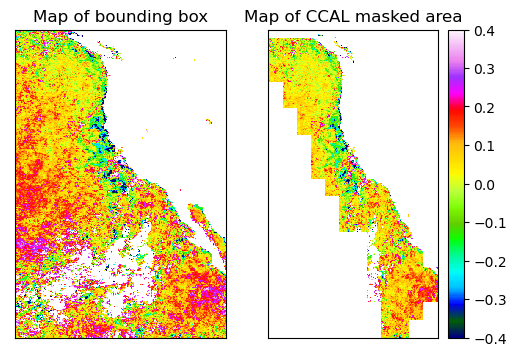

In [34]:
print(wa_flag)
if wa_flag:
    plot_ds = delta_ds
else:
    plot_ds = subsetted_ds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

ax1.set_title('Map of bounding box')
ax1.set_yticks([])
ax1.set_xticks([])

ax1.pcolormesh(plot_ds[7].reindex(latitude=list(reversed(plot_ds.latitude))),
                             vmin=-0.3, vmax=0.3,
                             cmap='gist_ncar')

ax2.set_title('Map of CCAL masked area')
ax2.set_yticks([])
ax2.set_xticks([])

pc = ax2.pcolormesh(delta_ds[7].reindex(latitude=list(reversed(delta_ds.latitude))),
                             vmin=-0.4, vmax=0.4,
                             cmap='gist_ncar')

fig.colorbar(pc)


## Appendix B: Steps for use without a shapefile
<a id='no_shapefile'></a>
### __Do not run this code if you have used a shapefile above!__
Use this method in place of cells tagged "Shapefile method".  

If you don't have a shapefile, you can just select a rectangular area that encompasses your area of interest. The area is define by a the maximum and minimum values of a latitude and a longitude range.   

__Steps__  
1. Load the geo_bnds dictionary with the minimum and maximum values for latitude and longitude the area of interest. 
* An area off the Oregon coast is used the example below:
    * Latitude range: 42.0&deg; to 46.0&deg; N  
    * Longitude range: -128.0&deg; to -124&deg; E
2. Proceed through the subsetting steps as listed below:
* Note that the masking steps have been omitted.
* The return from subset_ds() is labeled delta_ds.

In [ ]:
geo_bnds = {}
geo_bnds['lon_min'] = -128.
geo_bnds['lon_max'] = -123.
geo_bnds['lat_min'] = 42.
geo_bnds['lat_max'] = 52.


# Change this code "subsetted_ds = subset_ds(ds, erddap_var, geo_bnds)" to:
delta_ds = subset_ds(ds, erddap_var, geo_bnds)

# set workaround flag
wa_flag = True

# Omit create the mask
#mask = region.mask(subsetted_ds.longitude, subsetted_ds.latitude)

# Omit apply mask the the satellite data
#delta_ds = subsetted_ds.where(mask == region.numbers[0])
